In this project, we construct a deep neural network to classify image of Brazilian Jiu-Jitsu technics.

The images had been download from google search with related keyword, but are really noisy. We conducted a small pass on picturess to delete the less related to subject in train and test.


I don't have any GPU on my computer, so every train will be done with few epochs. It's more a way to improve my understanding of neural network than a project were results are really important.

In [21]:
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras import applications
from keras.models import Model
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

# 1 - Loading and preprocessing

Image are divided into two repository:
    - Train, which contain train sample.
    - Test, which contain sample to validate prediction on.
    
Each of this repository is then divided into 3 different repository: juji_gatame, triangle and kimura. Those are the BJJ technics that we will try to recognize.

In [22]:
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = '/home/thibault/Documents/TensorFlow/workspace/bjj_photos/train/'
validation_data_dir = '/home/thibault/Documents/TensorFlow/workspace/bjj_photos/test/'

We can see a lot of noise in pictures (many pictures are not in the right group). We display one picture for each groups.

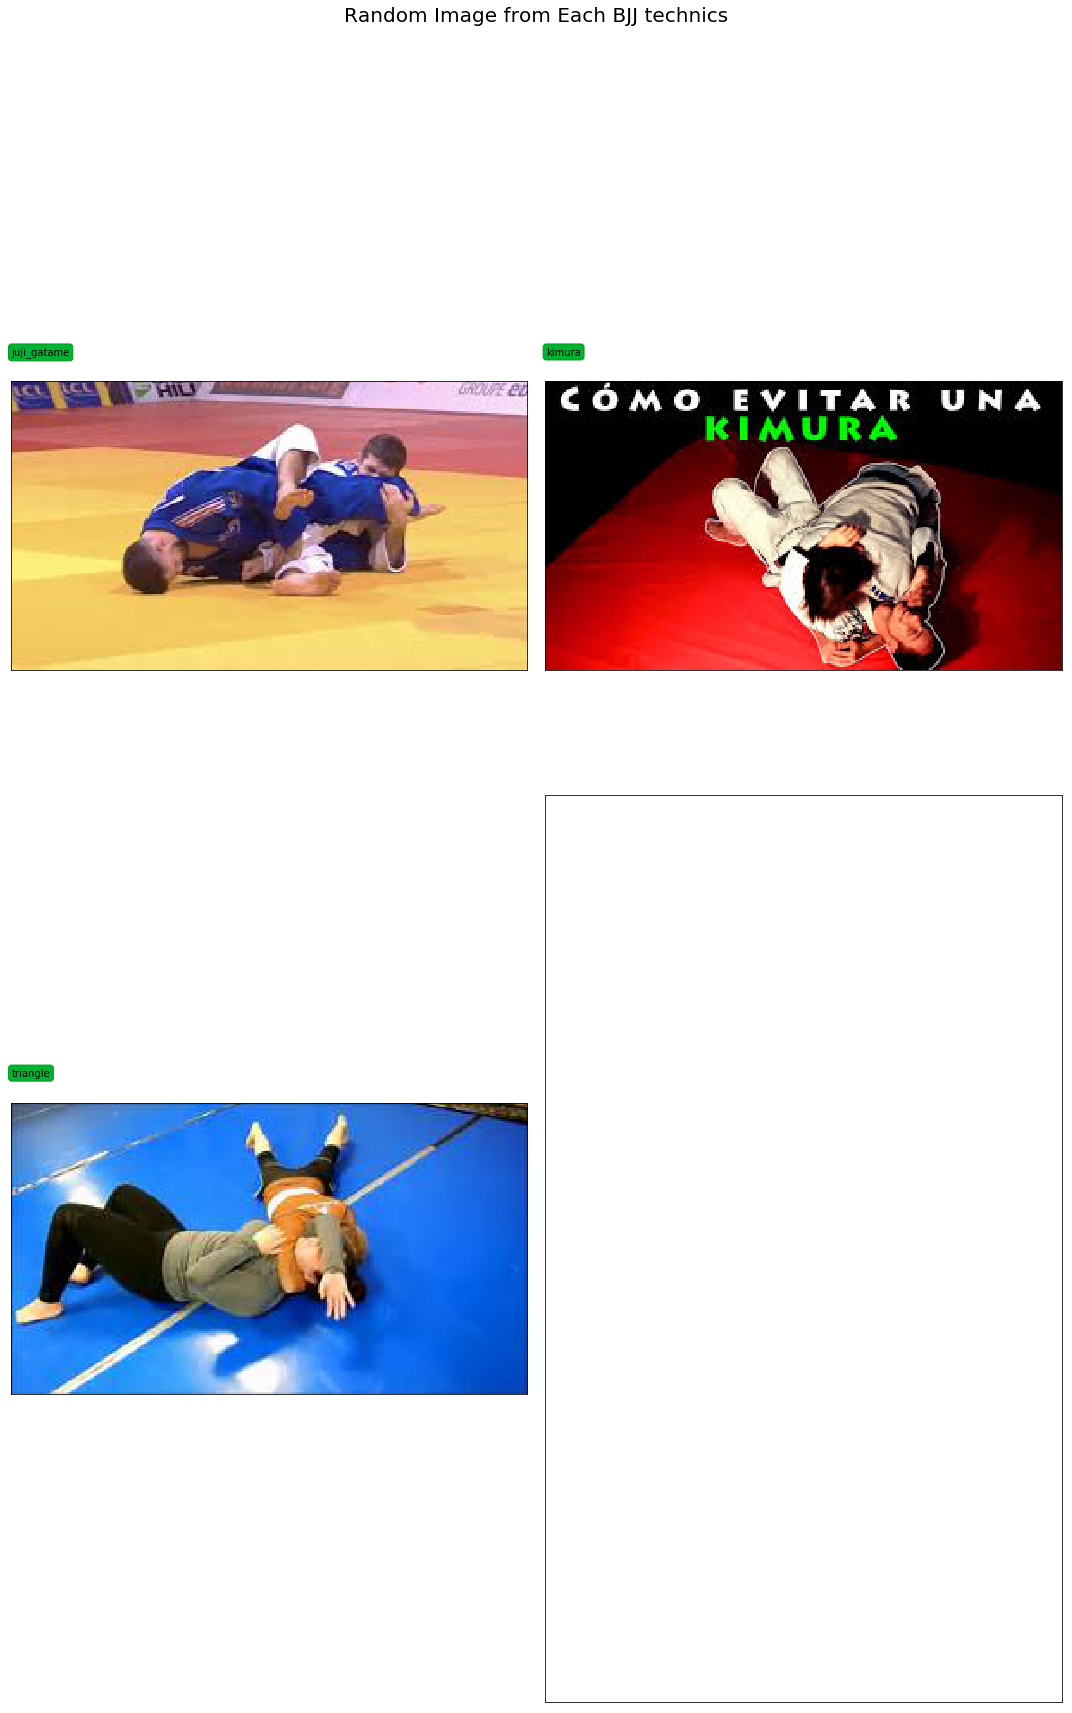

In [32]:
root_dir = '/home/thibault/Documents/TensorFlow/workspace/bjj_photos/train/'
rows = 2
cols = 2
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Random Image from Each BJJ technics', fontsize=20)
sorted_bjj_dirs = sorted(os.listdir(root_dir))
for i in range(rows):
    for j in range(cols):
        try:
            bjj_dir = sorted_bjj_dirs[i*cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, bjj_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, bjj_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, bjj_dir, size=10, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

We created batch of tensor Images. Image are looped over indefinitely.

    - target_size = DImension to which each image will be resized (150 * 150 in our case)
    - batch_size = Number of images sent in one iterations to the model (use less memory because we don't send the all dataset to the network, improving training time because weight are updated after each batch)
    - class_mode: type of data/result returned

In [24]:
##preprocessing
# used to rescale the pixel values from [0, 255] to [0, 1] interval
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 50

# automagically retrieve images and their classes for train and validation sets
train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

Found 618 images belonging to 3 classes.
Found 260 images belonging to 3 classes.


# 2 - Layers construction

In this part, we construct the differents layer used in our deep neural networks. The model is "Sequential", which mean it's a linear stack of layers.

We can see that the first layers receive input shape. It's mandatory in sequential model at least for the first layer to specify input characteristics.
We use mostly convolutional layers, with Convolution2D and MaxPolling2D. Convolutionals layers are used to take closest neigbor into account when applied to image recognition. We then used a sliding windows to be able to take a point and is neighbors to created a new output.

    - Convolutional2D: 
    - MaxPooling2D

In [25]:
model = Sequential()
# 1st layer
model.add(Convolution2D(32, (3, 3), input_shape=(img_width, img_height,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd layer
model.add(Convolution2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3nd layer
model.add(Convolution2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) # End by sigmoid activation because it's a classification problem

In the following part, we need to configure the learning process.
    - an optimizer: here we choose rmsprop, used most of the time for recurrent neural network.
    - a metrics: here we choose accuracy of predictions because we are facing a classification problem.
    - a loss functions: the objective that the model will try to minimize. binary_crossentropy is for binary logarithmic loss (logloss)

In [26]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# 3 - Training

In [27]:
epochs = 5
train_samples = 2048
validation_samples = 832

In [28]:
model.fit_generator(
        train_generator,
        steps_per_epoch=train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_samples// batch_size,)
#About 60 seconds an epoch when using CPU

Epoch 1/5
51/51 [==============================] - 85s - loss: -0.3555 - acc: 0.3529 - val_loss: 6.0833 - val_acc: 0.3658
Epoch 2/5
51/51 [==============================] - 77s - loss: -0.3629 - acc: 0.3451 - val_loss: 5.9461 - val_acc: 0.3649
Epoch 3/5
51/51 [==============================] - 108s - loss: -0.2080 - acc: 0.3434 - val_loss: 6.2046 - val_acc: 0.3514
Epoch 4/5
51/51 [==============================] - 109s - loss: -0.3082 - acc: 0.3487 - val_loss: 6.3123 - val_acc: 0.3581
Epoch 5/5
51/51 [==============================] - 119s - loss: -0.2972 - acc: 0.3478 - val_loss: 6.1615 - val_acc: 0.3676


In [29]:
model.save_weights('/home/thibault/Documents/TensorFlow/workspace/weight_bjj/basic_cnn_30_epochs.h5')

# 4 - Evaluation

In [30]:
model.load_weights('/home/thibault/Documents/TensorFlow/workspace/weight_bjj/basic_cnn_30_epochs.h5')

In [31]:
model.evaluate_generator(validation_generator, validation_samples)

[6.0673931848655629, 0.36543689360510567]

In [28]:
model.metrics_names

['loss', 'acc']

# 5 - Data augmentation

In [29]:
train_datagen_augmented = ImageDataGenerator(
        rescale=1./255,        # normalize pixel values to [0,1]
        shear_range=0.2,       # randomly applies shearing transformation
        zoom_range=0.2,        # randomly applies shearing transformation
        horizontal_flip=True)  # randomly flip the images

# same code as before
train_generator_augmented = train_datagen_augmented.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

Found 227 images belonging to 2 classes.


In [30]:
model.fit_generator(
        train_generator_augmented,
        steps_per_epoch=train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_samples // batch_size,)

Epoch 1/1
64/64 [==============================] - 61s - loss: 0.4568 - acc: 0.7943 - val_loss: 0.6228 - val_acc: 0.6756


In [31]:
model.save_weights('/home/thibault/Documents/TensorFlow/workspace/weight_bjj/augmented_30_epochs.h5')

In [32]:

model.evaluate_generator(validation_generator, validation_samples)

[0.60301631636826736, 0.68311737811692608]

# 6 - Using a pre-trained models

###### VGG16

In [33]:
model_vgg = applications.VGG16(include_top=False, weights='imagenet')

###### Process sample with VGG16

In [34]:
train_generator_bottleneck = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

validation_generator_bottleneck = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

Found 227 images belonging to 2 classes.
Found 410 images belonging to 2 classes.


In [35]:
bottleneck_features_train = model_vgg.predict_generator(train_generator_bottleneck, train_samples // batch_size)
np.save(open('/home/thibault/Documents/TensorFlow/workspace/weight_bjj/bottleneck_features_train.npy', 'wb'), 
        bottleneck_features_train)

In [36]:
bottleneck_features_validation =\
    model_vgg.predict_generator(validation_generator_bottleneck, validation_samples // batch_size)
np.save(open('/home/thibault/Documents/TensorFlow/workspace/weight_bjj/bottleneck_features_validation.npy', 'wb'), 
        bottleneck_features_validation)

In [37]:
train_data = np.load(open('/home/thibault/Documents/TensorFlow/workspace/weight_bjj/bottleneck_features_train.npy', 
                          'rb'))
train_labels = np.array([0] * (train_samples // 2) + [1] * (train_samples // 2))

validation_data = np.load(open('/home/thibault/Documents/TensorFlow/workspace/weight_bjj/bottleneck_features_validation.npy', 
                               'rb'))
validation_labels = np.array([0] * (validation_samples // 2) + [1] * (validation_samples // 2))

In [38]:
model_top = Sequential()
model_top.add(Flatten(input_shape=train_data.shape[1:]))
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(1, activation='sigmoid'))

model_top.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
model_top.fit(train_data, train_labels,
        epochs=epochs, 
        batch_size=batch_size,
        validation_data=(validation_data, validation_labels))

ValueError: Input arrays should have the same number of samples as target arrays. Found 1816 input samples and 2048 target samples.

In [ ]:
model_top.save_weights('/home/thibault/Documents/TensorFlow/workspace/weight_bjj/bottleneck_30_epochs.h5')

###### Bottleneck model evaluation

In [ ]:
model_top.evaluate(validation_data, validation_labels)